# 1. Introduction

The goal of this notebook is to preprocess a large dataset of mortgage loan applications to improve its quality and ensure the accuracy of a default prediction model.
Key steps include:
1. Data exploration
2. Handling missing values
3. Detecting and treating outliers
4. Cleaning noisy data
5. Feature engineering
6. Preparing the dataset for modeling


# 2. Library Imports

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configure visualization defaults
sns.set_style('white')
sns.set_palette('Set2')

# 3. Load Dataset

In [21]:
data_path = '/Users/hoale/Code/Mortgage_Loan_Data_Preprocessing/Loan_Default.csv'
df = pd.read_csv(data_path)

# Display basic dataset information
print(f'Dataset shape: {df.shape}')
df.head()

# Quick summary
df.info()
df.describe().T

Dataset shape: (148670, 34)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  U

,count,mean,std,min,25%,50%,75%,max
ID,148670.0,99224.500000,42917.476598,24890.000000,62057.25000,99224.50000,136391.750000,1.735590e+05
year,148670.0,2019.000000,0.000000,2019.000000,2019.00000,2019.00000,2019.000000,2.019000e+03
loan_amount,148670.0,331117.743997,183909.310127,16500.000000,196500.00000,296500.00000,436500.000000,3.576500e+06
rate_of_interest,112231.0,4.045476,0.561391,0.000000,3.62500,3.99000,4.375000,8.000000e+00
Interest_rate_spread,112031.0,0.441656,0.513043,-3.638000,0.07600,0.39040,0.775400,3.357000e+00
Upfront_charges,109028.0,3224.996127,3251.121510,0.000000,581.49000,2596.45000,4812.500000,6.000000e+04
term,148629.0,335.136582,58.409084,96.000000,360.00000,360.00000,360.000000,3.600000e+02
property_value,133572.0,497893.465696,359935.315562,8000.000000,268000.00000,418000.00000,628000.000000,1.650800e+07
income,139520.0,6957.338876,6496.586382,0.000000,3720.00000,5760.00000,8520.000000,5.785800e+05
Credit_Score,148670.0,699.789103,115.875857,500.000000,599.00000,699.00000,800.000000,9.000000e+02


'Status' is the target variable. From this statistic table, we can see that about 25% of the loans are defaulted.

# 4. Data Cleaning

In [22]:
# Remove year and ID
df = df.drop(['year','ID'], axis=1)

# Convert all columns to lowercase
df.columns = df.columns.str.lower()

# Removing duplicates
df = df.drop_duplicates()
print(f'Shape after removing duplicates: {df.shape}')

Shape after removing duplicates: (148670, 32)


In [23]:
# Convert object columns to category
obj_cols = df.select_dtypes(['object']).columns
df[obj_cols] = df[obj_cols].astype('category')

# Convert categorical columns to lowercase (standardization)
cat_cols = df.select_dtypes(['category']).columns
df[cat_cols] = df[cat_cols].apply(lambda x: x.str.lower())

In [24]:
# Display unique values for each categorical column
for col in cat_cols:
    print(col + ' ' + '-'*(30-len(col)) + ' ', df[col].unique())

loan_limit --------------------  ['cf' nan 'ncf']
gender ------------------------  ['sex not available' 'male' 'joint' 'female']
approv_in_adv -----------------  ['nopre' 'pre' nan]
loan_type ---------------------  ['type1' 'type2' 'type3']
loan_purpose ------------------  ['p1' 'p4' 'p3' 'p2' nan]
credit_worthiness -------------  ['l1' 'l2']
open_credit -------------------  ['nopc' 'opc']
business_or_commercial --------  ['nob/c' 'b/c']
neg_ammortization -------------  ['not_neg' 'neg_amm' nan]
interest_only -----------------  ['not_int' 'int_only']
lump_sum_payment --------------  ['not_lpsm' 'lpsm']
construction_type -------------  ['sb' 'mh']
occupancy_type ----------------  ['pr' 'sr' 'ir']
secured_by --------------------  ['home' 'land']
total_units -------------------  ['1u' '2u' '3u' '4u']
credit_type -------------------  ['exp' 'equi' 'crif' 'cib']
co-applicant_credit_type ------  ['cib' 'exp']
age ---------------------------  ['25-34' '55-64' '35-44' '45-54' '65-74' '>74' '<2

In [25]:
df.replace({'sex not available': np.nan}, inplace=True)

In [26]:
# Convert target variable to category
df['status'] = df['status'].astype('category')

# 5. Handling Missing Values

In [27]:
# Check missing values percentage
missing_percent = df.isnull().mean() * 100
print('Missing Values Percentage:\n', missing_percent[missing_percent > 0].sort_values(ascending=False), sep='')

Missing Values Percentage:
upfront_charges              26.664425
gender                       25.330598
interest_rate_spread         24.644515
rate_of_interest             24.509989
dtir1                        16.224524
property_value               10.155378
ltv                          10.155378
income                        6.154571
loan_limit                    2.249277
approv_in_adv                 0.610749
age                           0.134526
submission_of_application     0.134526
loan_purpose                  0.090133
neg_ammortization             0.081388
term                          0.027578
dtype: float64


Missing values percentage ranges from 0.02% to 26.66%. Since it will be a waste to drop any of these columns, we will instead impute them with appropriate values.

In [28]:
# Impute numerical columns with median (except for dtir1 and ltv)
num_cols = df.select_dtypes(['float64','int64']).columns
ratio_cols = ['dtir1', 'ltv']
num_cols = num_cols.drop(ratio_cols)
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Impute dtir1 and ltv with actual calculation
# df['dtir1'] = df['dtir1'].fillna(df['loan_amount']/df['income'])
# df['ltv'] = df['ltv'].fillna(df['loan_amount']/df['property_value'])

# Impute categorical columns with mode
df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode())

# 6. Exploratory Data Analysis (EDA)

## Target variable

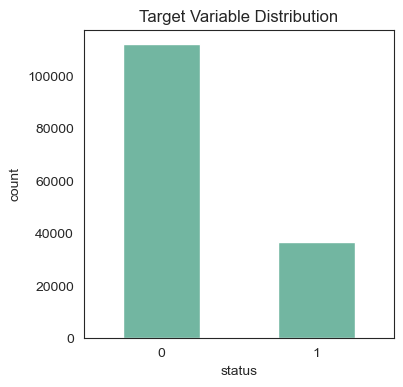

In [29]:
# Distribution of target variable
plt.figure(figsize=(4, 4))
sns.countplot(x='status', data=df, width=0.5)
plt.title('Target Variable Distribution')
plt.show()

## Categorical variables

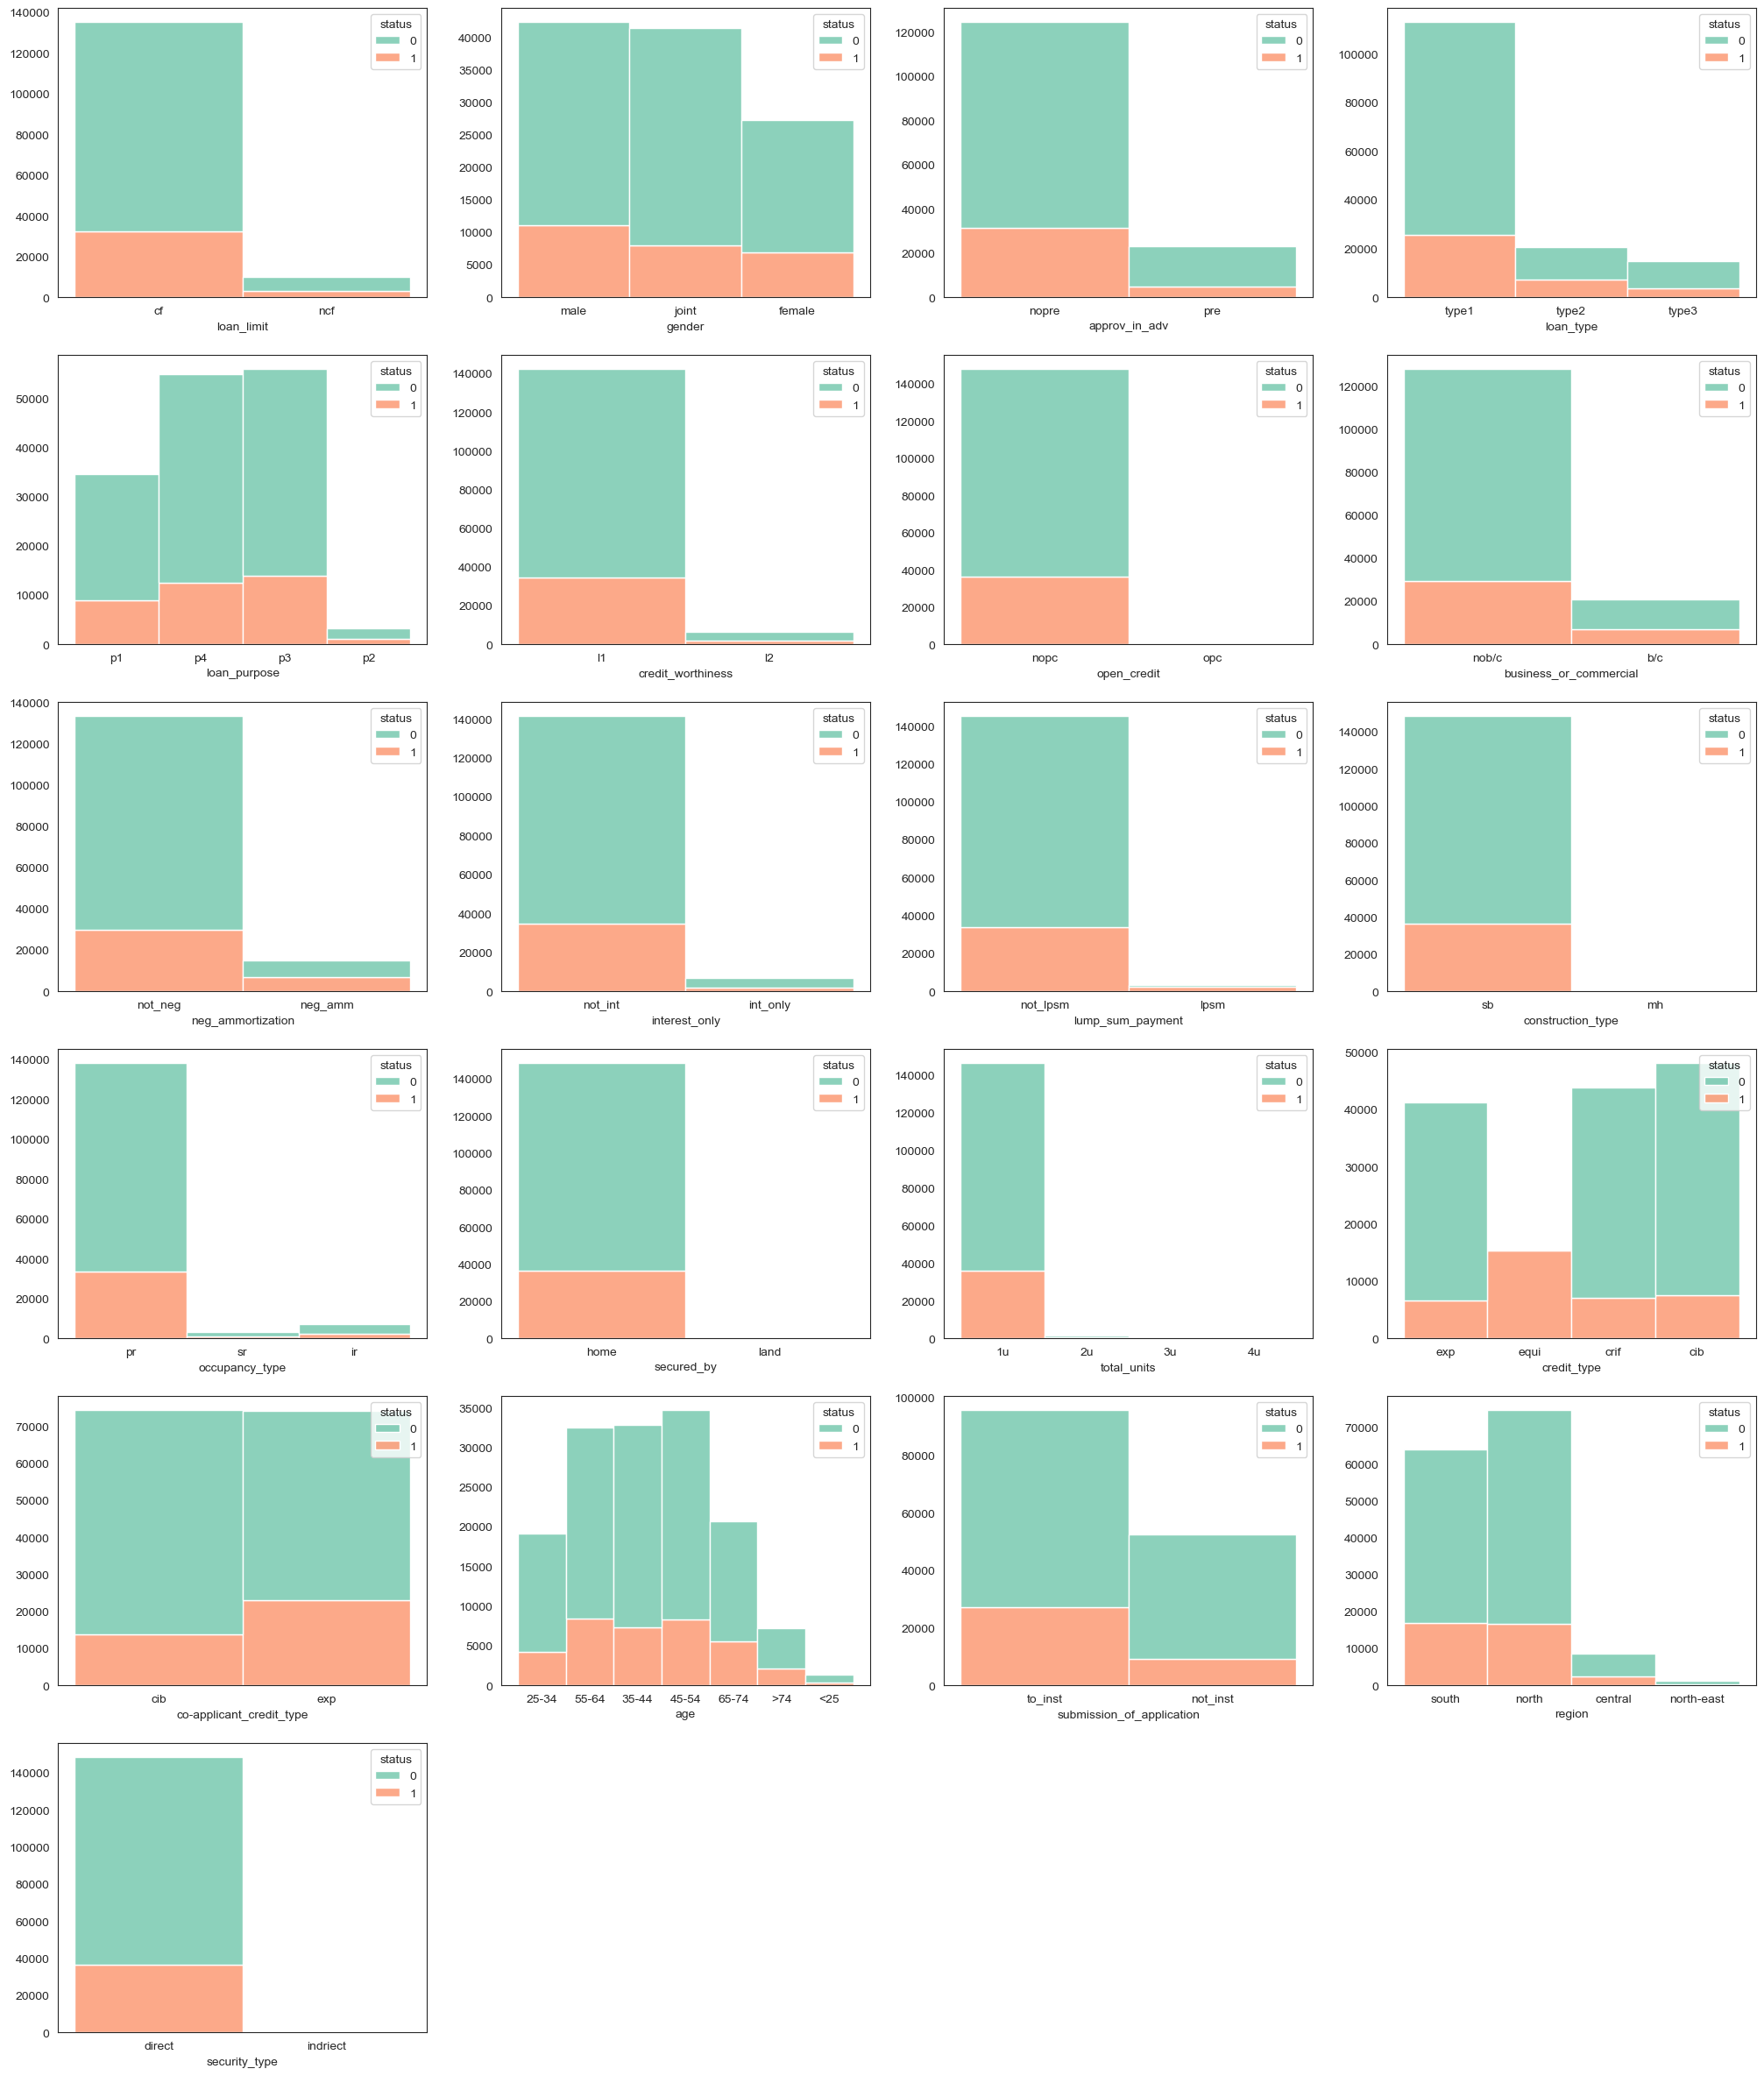

In [30]:
f1 = plt.figure(figsize=(25,30))
for col in cat_cols:
    i = cat_cols.to_list().index(col) + 1
    ax = f1.add_subplot(6,4,i)
    g1 = sns.histplot(df, x=df[col], legend=True, hue='status', multiple='stack')
    g1.set(ylabel=None)
plt.show()

Some features have significant imbalance distribution among its values which is not meaningful in making predictionss. Therefore, we will **remove** those features of which one value appears in **97% or more** of records.

In [31]:
for col in ['loan_limit', 'credit_worthiness', 'open_credit', 'interest_only', 
            'lump_sum_payment', 'construction_type', 'occupancy_type','secured_by',
            'total_units', 'security_type']:
    print(df[col].value_counts()/len(df)*100, '\n')

loan_limit
cf     91.039214
ncf     6.711509
Name: count, dtype: float64 

credit_worthiness
l1    95.744938
l2     4.255062
Name: count, dtype: float64 

open_credit
nopc    99.626017
opc      0.373983
Name: count, dtype: float64 

interest_only
not_int     95.217596
int_only     4.782404
Name: count, dtype: float64 

lump_sum_payment
not_lpsm    97.723818
lpsm         2.276182
Name: count, dtype: float64 

construction_type
sb    99.977803
mh     0.022197
Name: count, dtype: float64 

occupancy_type
pr    92.958230
ir     4.937109
sr     2.104661
Name: count, dtype: float64 

secured_by
home    99.977803
land     0.022197
Name: count, dtype: float64 

total_units
1u    98.526939
2u     0.993475
3u     0.264344
4u     0.215242
Name: count, dtype: float64 

security_type
direct      99.977803
indriect     0.022197
Name: count, dtype: float64 



Features to be **removed**: open_credit, construction_type, secured_by, total_units, security_type.


In [32]:
# Drop meaningless columns 
meaningless_cols = ['open_credit', 'lump_sum_payment', 'construction_type', 'secured_by', 'total_units', 'security_type']
df = df.drop(meaningless_cols, axis=1)
cat_cols.drop(col)

## Numerical variables

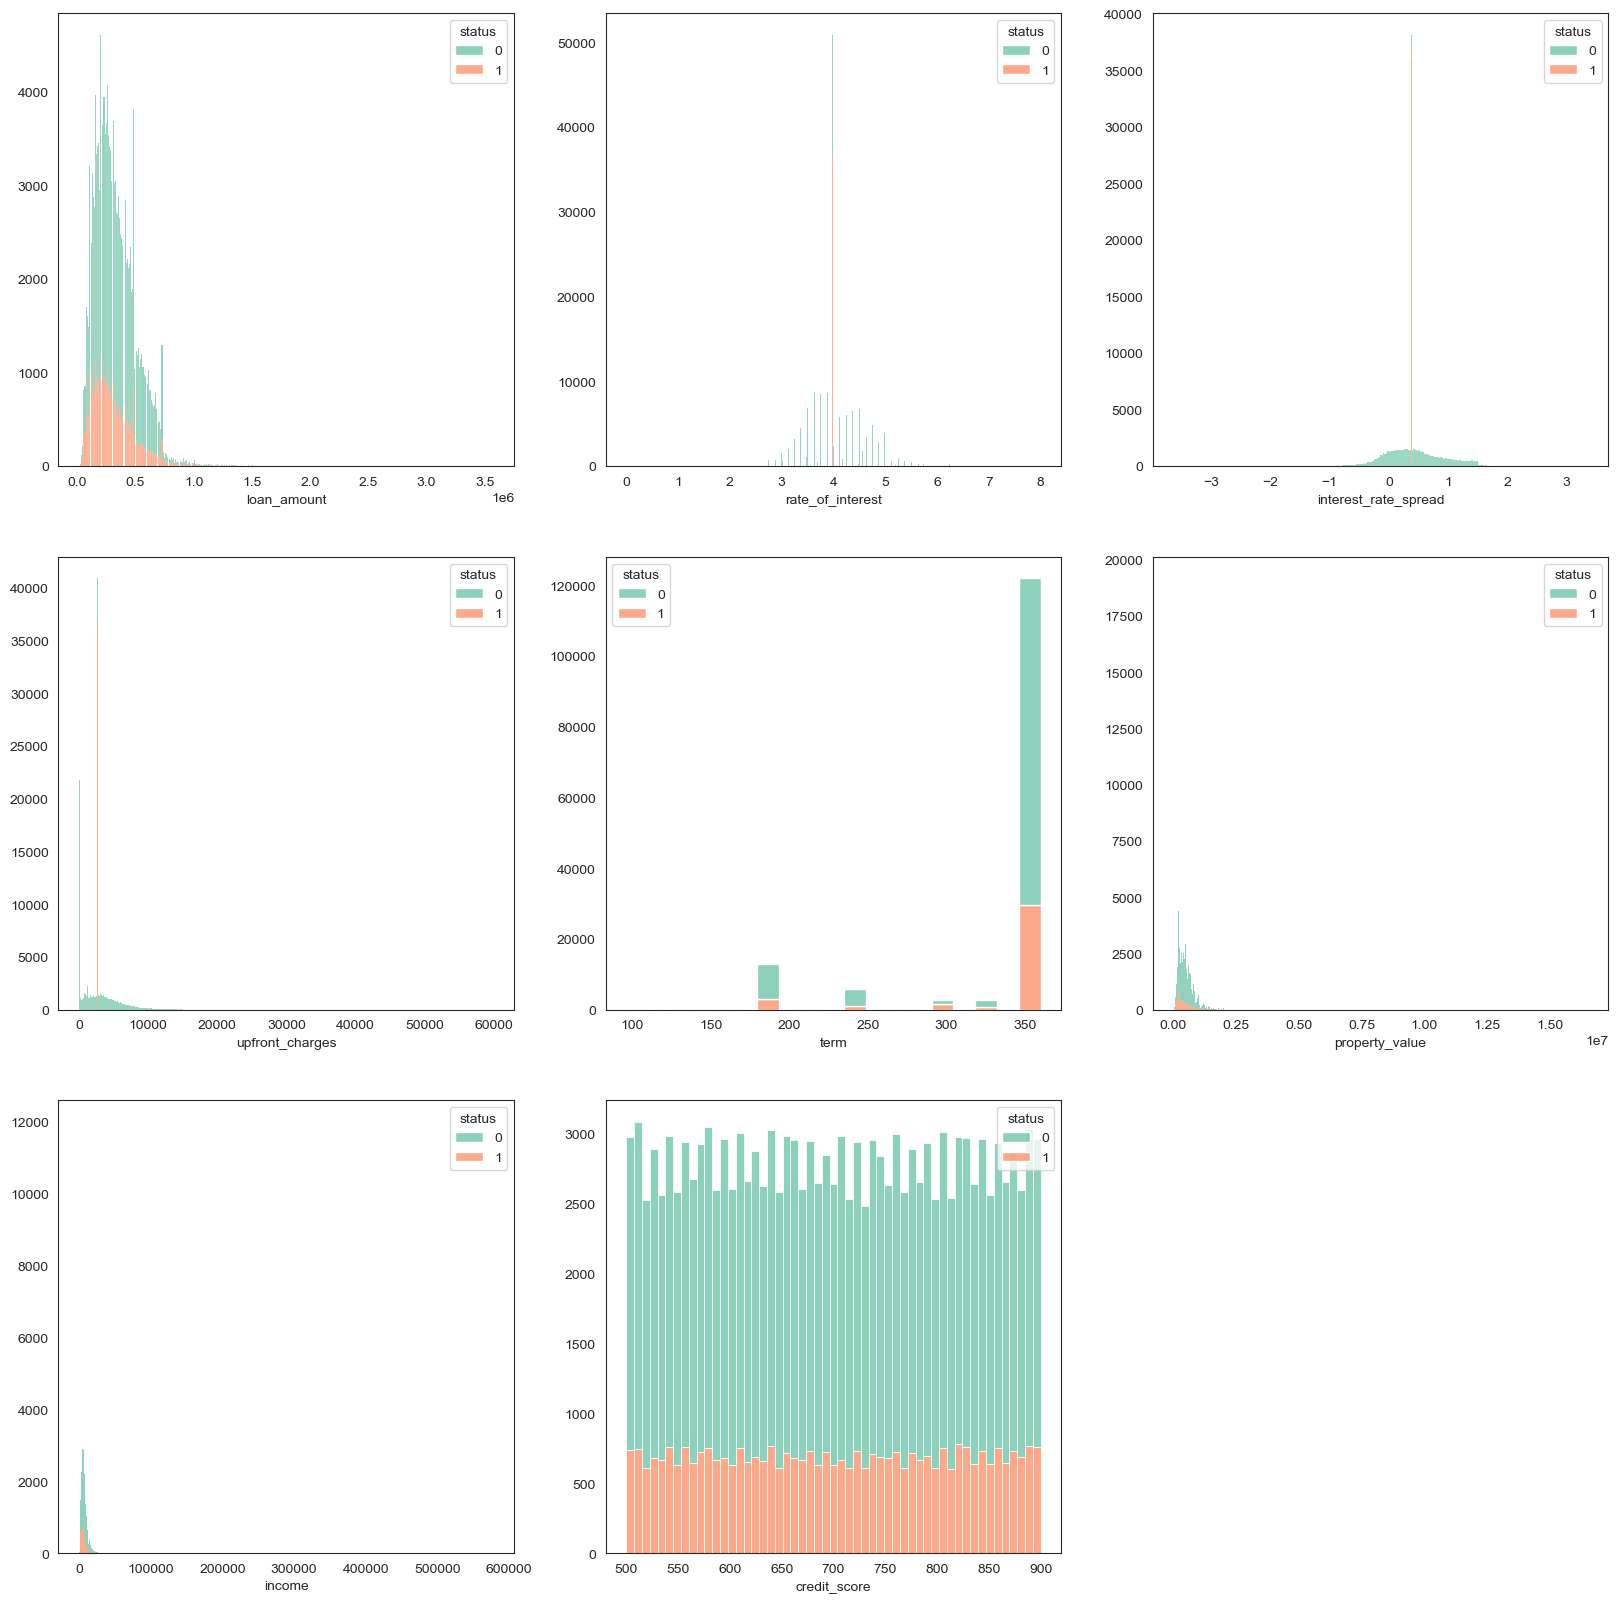

In [33]:
f1 = plt.figure(figsize=(20,20))
for col in num_cols:
    i = num_cols.to_list().index(col) + 1
    ax = f1.add_subplot(3,3,i)
    g1 = sns.histplot(df, x=df[col], legend=True, hue='status', multiple='stack')
    g1.set(ylabel=None)
plt.show()

Credit_score can be **removed** because the ratio between default and non-defaut loans remain unchanged at all levels.

In [34]:
df = df.drop('credit_score', axis=1)

# 7. Outlier and Noise Detection

### Loan amount

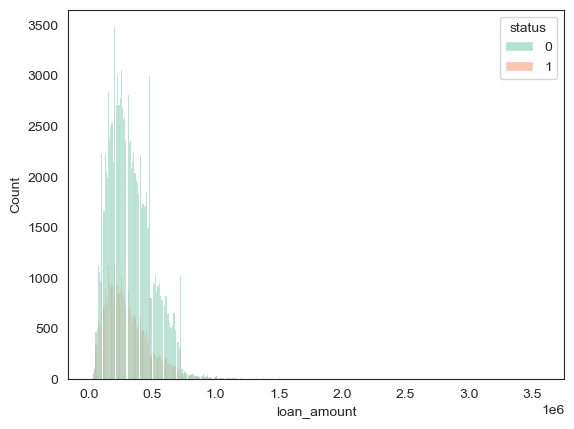

In [35]:
sns.histplot(df, x=df['loan_amount'], legend=True, hue='status',)
plt.show()

In [36]:
df.loan_amount.sort_values(ascending=False)

4321      3576500
98146     3346500
86408     3006500
3762      3006500
54519     3006500
           ...   
89973       26500
113985      26500
135325      16500
136556      16500
124860      16500
Name: loan_amount, Length: 148670, dtype: int64

In [37]:
df['loan_amount'] = df['loan_amount']-6500

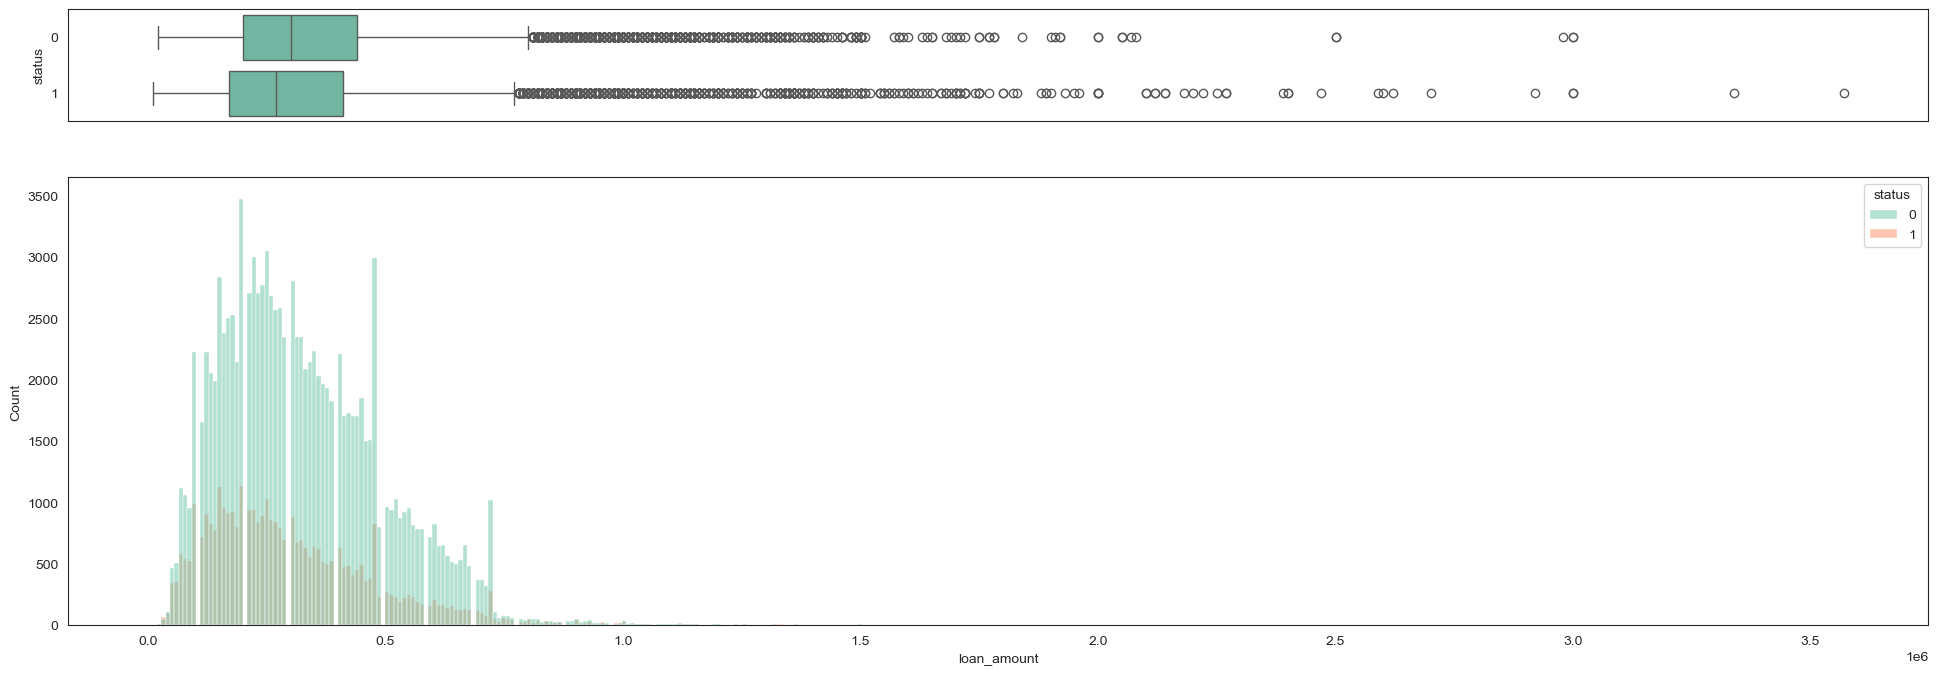

In [38]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.2, .8)},figsize=(24,8))
 
# assigning a graph to each ax
sns.boxplot(df, x='loan_amount', y='status', orient='h', ax=ax_box)
sns.histplot(df, x='loan_amount', hue='status', ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
plt.show()

### Property value

In [ ]:
df['property_value'].sort_values(ascending=False)

In [31]:
df['property_value'] = df['property_value']-8000

### Income

In [ ]:
df['income'].value_counts(ascending=False)

In [ ]:
df['income'].sort_values(ascending=False)

In [ ]:
# Correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [10]:
# Using IQR for outlier detection
def treat_outliers_iqr(column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.clip(df[column], lower_bound, upper_bound)

for col in num_cols:
    treat_outliers_iqr(col)

# 8. Feature Engineering

In [ ]:
# Log-transform skewed numerical features
from scipy.stats import skew

skewed_features = df[num_cols].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skewed_features[abs(skewed_features) > 0.75].index

for col in high_skew:
    df[col] = np.log1p(df[col])

# One-hot encode categorical variables
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# 9. Data Transformation

In [ ]:
# Scaling numerical features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

print('Dataset after scaling and encoding:')
df.head()

# 10. Save the Preprocessed Dataset

In [13]:
# Save the preprocessed dataset
df.to_csv('preprocessed_dataset.csv', index=False)